# Project 71: Automatic Image Caption Generation Attention

## Authors: Oihane Cantero and Julen Etxaniz

## Supervisors: Oier Lopez de Lacalle and Eneko Agirre

## Subject: Machine Learning and Neural Networks

## Date: 20-12-2020

## Objectives: 
### 1. Implement a caption generation model that uses a CNN to condition a LSTM based language model.
### **2. Extend the basic caption generation system that incorporates an attention mechanism to the model.**

## Contents:
### 1. Prepare Colab
### 2. Import Libraries
### 3. Prepare Text Data
### 4. Load Data
### 5. Encode Text Data
### 6. Prepare Photo Data
### 7. Define Model
### 8. Fit Model
### 9. Evaluate Model
### 10. Generate Captions

## References
[1] https://arxiv.org/pdf/1502.03044.pdf

[2] https://www.tensorflow.org/tutorials/text/image_captioning?hl=en

[3] https://medium.com/swlh/image-captioning-using-attention-mechanism-f3d7fc96eb0e

[4] https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/

# Prepare Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/1. Lauhilekoa/MLNN/Projects/Topic 3 Deep Neural Networks/neural-caption-generation/notebook

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/1. Lauhilekoa/MLNN/Projects/Topic 3 Deep Neural Networks/neural-caption-generation/notebook


In [ ]:
%cd /content/drive/MyDrive/4/MLNN/P3/neural-caption-generation/notebook

/content/drive/.shortcut-targets-by-id/1yKqinuPu4oBVyhJ-8IMgknNyE2cmqrcs/neural-caption-generation/notebook


# Import Libraries

In [ ]:
import string
import numpy as np
from pickle import load
from os.path import isfile

from pickle import dump
import matplotlib.pyplot as plt

import time
import warnings
#warnings.filterwarnings("ignore")

import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

from sklearn.utils import shuffle
from IPython.display import Image, display
from itertools import repeat

# Get Dataset

We decided to use Flickr8k Dataset. It can be downloaded from: https://github.com/jbrownlee/Datasets/releases/tag/Flickr8k

It has 8092 images and 5 captions for each image. Each image has 5 captions because obviously, there are different ways to caption an image. This dataset has predefined training, testing and evaluation subsets of 6000, 1000 and 1000 images respectively.

# Prepare Text Data

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [ ]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


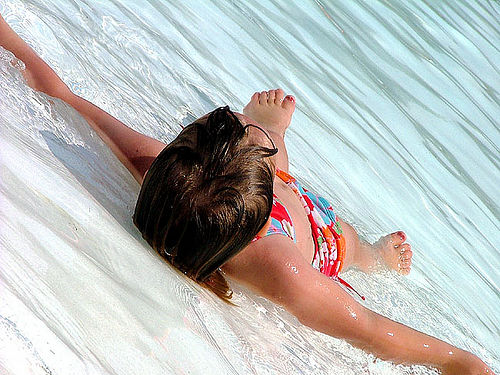

In [ ]:
example_image = "Flickr8k_Dataset/667626_18933d713e.jpg"
display(Image(example_image))

In [ ]:
example_id = '667626_18933d713e'
descriptions[example_id]

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 'A young girl is lying in the sand , while ocean water is surrounding her .',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [ ]:
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'files/descriptions.txt')

Vocabulary Size: 8763


In [ ]:
descriptions[example_id]

['girl is stretched out in shallow water',
 'girl wearing red and multicolored bikini is laying on her back in shallow water',
 'little girl in red swimsuit is laying on her back in shallow water',
 'young girl is lying in the sand while ocean water is surrounding her',
 'girl wearing bikini lying on her back in shallow pool of clear blue water']

# Load Data

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = '<start> ' + ' '.join(image_desc) + ' <end>'
			# store
			descriptions[image_id].append(desc)
	return descriptions

## Train Data

In [ ]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# one image name per caption
img_name_train = [x for item in train for x in repeat(item, 5)]
# descriptions
train_descriptions = load_clean_descriptions('files/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Dataset: 6000
Descriptions: train=6000


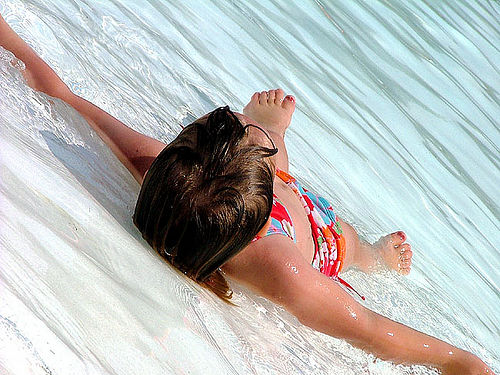

In [ ]:
display(Image(example_image))

In [ ]:
# <start> and <end> added
train_descriptions[example_id]

['<start> girl is stretched out in shallow water <end>',
 '<start> girl wearing red and multicolored bikini is laying on her back in shallow water <end>',
 '<start> little girl in red swimsuit is laying on her back in shallow water <end>',
 '<start> young girl is lying in the sand while ocean water is surrounding her <end>',
 '<start> girl wearing bikini lying on her back in shallow pool of clear blue water <end>']

## Validation Data

In [ ]:
# load val dataset
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
val = load_set(filename)
print('Dataset: %d' % len(val))
# one image name per caption
img_name_val = [x for item in val for x in repeat(item, 5)]
# descriptions
val_descriptions = load_clean_descriptions('files/descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))

Dataset: 1000
Descriptions: val=1000


## Test Data

In [ ]:
# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# one image name per caption
img_name_test = [x for item in test for x in repeat(item, 5)]
# descriptions
test_descriptions = load_clean_descriptions('files/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Dataset: 1000
Descriptions: test=1000


# Encode Text Data

In [ ]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [ ]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions, top_k):
    lines = to_lines(descriptions)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(lines)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    return tokenizer

In [ ]:
# calculate the length of the description with the most words
def max_len(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [ ]:
def tokenize_captions(descriptions):
    caps_lists = list(descriptions.values())
    caps_list = [item for sublist in caps_lists for item in sublist]
    cap_seqs = tokenizer.texts_to_sequences(caps_list)
    cap_seqs = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')
    return cap_seqs

In [ ]:
# prepare tokenizer
filename = 'files/tokenizer2.pkl'
# only create tokenizer if it does not exist
top_k = 5000
if not isfile(filename):
    tokenizer = create_tokenizer(train_descriptions, top_k)
    # save the tokenizer
    dump(tokenizer, open(filename, 'wb'))
else:
    tokenizer = load(open(filename, 'rb'))
# define vocabulary size
vocab_size = top_k + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_len(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 5001
Description Length: 34


In [ ]:
# 10 most common words
list(tokenizer.word_index.items())[:10]

[('<unk>', 1),
 ('<start>', 2),
 ('<end>', 3),
 ('in', 4),
 ('the', 5),
 ('on', 6),
 ('is', 7),
 ('and', 8),
 ('dog', 9),
 ('with', 10)]

In [ ]:
# 10 least common words
list(tokenizer.word_index.items())[-10:]

[('swatting', 7571),
 ('containig', 7572),
 ('rainstorm', 7573),
 ('breezeway', 7574),
 ('cocker', 7575),
 ('spaniels', 7576),
 ('majestically', 7577),
 ('scrolled', 7578),
 ('patterns', 7579),
 ('<pad>', 0)]

In [ ]:
# tokenize captions
cap_train = tokenize_captions(train_descriptions)
cap_val = tokenize_captions(val_descriptions)
cap_test = tokenize_captions(test_descriptions)

# Prepare Photo Data

In [ ]:
def load_image(image_path):
    full_path = 'Flickr8k_Dataset/' + image_path + '.jpg'
    img = tf.io.read_file(full_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

In [ ]:
def image_model():
    cnn_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = cnn_model.input
    hidden_layer = cnn_model.layers[-1].output

    model = tf.keras.Model(new_input, hidden_layer)
    model.summary()
    return model

In [ ]:
image_model = image_model()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

In [ ]:
# union of all image names
img_name_vector = train | val | test
encode_images = sorted(set(img_name_vector))
# create dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_images)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
for img, path in tqdm(image_dataset, position=0, leave=True):
    batch_features = image_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = 'features/' + p.numpy().decode("utf-8") + '.jpg'
        np.save(path_of_feature, bf.numpy())

100%|██████████| 125/125 [18:56<00:00,  9.09s/it]


# Define Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # 
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                                                     beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                                                                     beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)


        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, mem_state, carry_state = self.lstm(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        x= self.dropout(x)
        x= self.batchnormalization(x)

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, mem_state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
embedding_dim = 256
units = 512
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# Fit Model

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
features_shape = 512
attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load('features/' + img_name.decode('utf-8') + '.jpg.npy')
    return img_tensor, cap

In [ ]:
def create_dataset(img_name, cap):
    dataset = tf.data.Dataset.from_tensor_slices((img_name, cap))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = create_dataset(img_name_train, cap_train)
val_dataset = create_dataset(img_name_val, cap_val)

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden,_ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
@tf.function 
def val_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))
    return loss, avg_loss

In [ ]:
EPOCHS = 10
loss_plot = []
val_loss_plot = []
best_val_loss = float("inf")
start_epoch = 0
num_steps_train = len(img_name_train) // BATCH_SIZE
num_steps_val = len(img_name_val) // BATCH_SIZE
start = time.time()

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    total_val_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(train_dataset), position=0, leave=True):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            loss = batch_loss.numpy() / int(target.shape[1])
            
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, loss))            
                    
    for (batch_val, (img_tensor_val, target_val)) in enumerate(val_dataset):
        batch_val_loss, t_val_loss = val_step(img_tensor_val, target_val)
        total_val_loss += t_val_loss

    # storing the epoch end loss value to plot later
    loss_mean = total_loss / num_steps_train
    loss_plot.append(loss_mean)
    # storing the epoch end val_loss value to plot later
    val_loss_mean = total_val_loss / num_steps_val
    val_loss_plot.append(val_loss_mean)
    
    print('Epoch {} Loss {:.6f} Val Loss {:.6f}'.format(epoch + 1, loss_mean, val_loss_mean))

    if val_loss_mean < best_val_loss:
        print('val_loss improved from %.4f to %.4f' % (best_val_loss, val_loss_mean))
        best_val_loss = val_loss_mean
        encoder.save_weights('models/cnn_encoder.h5')
        decoder.save_weights('models/rnn_decoder.h5')
    else:
        print('val_loss did not improve from %.4f' % (best_val_loss))

2it [00:37, 26.06s/it]

Epoch 1 Batch 0 Loss 2.4338


102it [00:49,  8.02it/s]

Epoch 1 Batch 100 Loss 1.8125


202it [01:01,  8.16it/s]

Epoch 1 Batch 200 Loss 1.5214


302it [01:14,  8.15it/s]

Epoch 1 Batch 300 Loss 1.2232


402it [01:26,  8.13it/s]

Epoch 1 Batch 400 Loss 1.4321


469it [01:54,  4.08it/s]
0it [00:00, ?it/s]

Epoch 1 Loss 1.523474 Val Loss 1.473535
val_loss improved from inf to 1.4735


2it [00:01,  1.30it/s]

Epoch 2 Batch 0 Loss 1.3599


102it [00:13,  8.04it/s]

Epoch 2 Batch 100 Loss 1.2444


202it [00:25,  7.78it/s]

Epoch 2 Batch 200 Loss 1.3443


302it [00:38,  8.04it/s]

Epoch 2 Batch 300 Loss 1.1963


402it [00:50,  8.22it/s]

Epoch 2 Batch 400 Loss 1.3654


469it [00:58,  7.99it/s]
0it [00:00, ?it/s]

Epoch 2 Loss 1.232895 Val Loss 1.395596
val_loss improved from 1.4735 to 1.3956


2it [00:01,  1.31it/s]

Epoch 3 Batch 0 Loss 1.1350


102it [00:13,  8.10it/s]

Epoch 3 Batch 100 Loss 1.1065


202it [00:25,  8.46it/s]

Epoch 3 Batch 200 Loss 1.1280


302it [00:38,  8.06it/s]

Epoch 3 Batch 300 Loss 1.1191


402it [00:50,  8.15it/s]

Epoch 3 Batch 400 Loss 1.0851


469it [00:58,  7.99it/s]
0it [00:00, ?it/s]

Epoch 3 Loss 1.148720 Val Loss 1.382007
val_loss improved from 1.3956 to 1.3820


2it [00:01,  1.34it/s]

Epoch 4 Batch 0 Loss 1.1200


102it [00:13,  7.85it/s]

Epoch 4 Batch 100 Loss 1.0316


202it [00:25,  8.40it/s]

Epoch 4 Batch 200 Loss 1.1107


302it [00:38,  8.28it/s]

Epoch 4 Batch 300 Loss 1.0040


402it [00:50,  7.98it/s]

Epoch 4 Batch 400 Loss 1.0376


469it [00:58,  7.95it/s]
0it [00:00, ?it/s]

Epoch 4 Loss 1.089072 Val Loss 1.388811
val_loss did not improve from 1.3820


2it [00:01,  1.22it/s]

Epoch 5 Batch 0 Loss 1.1010


102it [00:13,  7.96it/s]

Epoch 5 Batch 100 Loss 1.0032


202it [00:26,  8.12it/s]

Epoch 5 Batch 200 Loss 0.9563


302it [00:38,  7.99it/s]

Epoch 5 Batch 300 Loss 1.0322


402it [00:51,  8.07it/s]

Epoch 5 Batch 400 Loss 1.0974


469it [00:59,  7.89it/s]
0it [00:00, ?it/s]

Epoch 5 Loss 1.033187 Val Loss 1.415051
val_loss did not improve from 1.3820


2it [00:01,  1.32it/s]

Epoch 6 Batch 0 Loss 0.9991


102it [00:13,  7.98it/s]

Epoch 6 Batch 100 Loss 1.0295


202it [00:26,  7.81it/s]

Epoch 6 Batch 200 Loss 1.0585


302it [00:38,  8.19it/s]

Epoch 6 Batch 300 Loss 0.9545


402it [00:50,  8.32it/s]

Epoch 6 Batch 400 Loss 0.9737


469it [00:58,  7.96it/s]
0it [00:00, ?it/s]

Epoch 6 Loss 0.975673 Val Loss 1.458074
val_loss did not improve from 1.3820


2it [00:01,  1.33it/s]

Epoch 7 Batch 0 Loss 0.9634


102it [00:13,  8.06it/s]

Epoch 7 Batch 100 Loss 0.8474


202it [00:25,  8.18it/s]

Epoch 7 Batch 200 Loss 1.0203


302it [00:38,  8.09it/s]

Epoch 7 Batch 300 Loss 0.8819


402it [00:50,  7.86it/s]

Epoch 7 Batch 400 Loss 0.8872


469it [00:59,  7.95it/s]
0it [00:00, ?it/s]

Epoch 7 Loss 0.916104 Val Loss 1.509175
val_loss did not improve from 1.3820


2it [00:01,  1.34it/s]

Epoch 8 Batch 0 Loss 0.8290


102it [00:13,  8.19it/s]

Epoch 8 Batch 100 Loss 0.9265


202it [00:26,  8.20it/s]

Epoch 8 Batch 200 Loss 0.9076


302it [00:38,  8.09it/s]

Epoch 8 Batch 300 Loss 0.7734


402it [00:50,  7.70it/s]

Epoch 8 Batch 400 Loss 0.9187


469it [00:58,  7.96it/s]
0it [00:00, ?it/s]

Epoch 8 Loss 0.857671 Val Loss 1.549506
val_loss did not improve from 1.3820


2it [00:01,  1.29it/s]

Epoch 9 Batch 0 Loss 0.8270


102it [00:13,  8.16it/s]

Epoch 9 Batch 100 Loss 0.8027


202it [00:26,  7.61it/s]

Epoch 9 Batch 200 Loss 0.7895


302it [00:38,  8.24it/s]

Epoch 9 Batch 300 Loss 0.7603


402it [00:51,  7.95it/s]

Epoch 9 Batch 400 Loss 0.7871


469it [00:59,  7.91it/s]
0it [00:00, ?it/s]

Epoch 9 Loss 0.801985 Val Loss 1.603748
val_loss did not improve from 1.3820


2it [00:01,  1.30it/s]

Epoch 10 Batch 0 Loss 0.7575


102it [00:13,  8.22it/s]

Epoch 10 Batch 100 Loss 0.7500


202it [00:25,  8.04it/s]

Epoch 10 Batch 200 Loss 0.7134


302it [00:38,  8.11it/s]

Epoch 10 Batch 300 Loss 0.7319


402it [00:50,  8.02it/s]

Epoch 10 Batch 400 Loss 0.7724


469it [00:58,  8.00it/s]


Epoch 10 Loss 0.749895 Val Loss 1.653260
val_loss did not improve from 1.3820


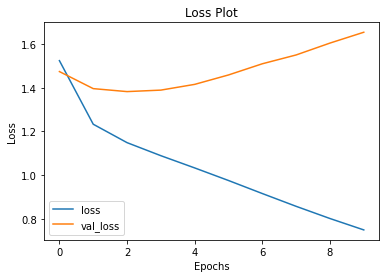

In [ ]:
plt.plot(loss_plot, label='loss')
plt.plot(val_loss_plot, label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evaluate Model

## Sampling

In [ ]:
def generate_desc(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = ['<start>']

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    result = ' '.join(result)
    return result, attention_plot

## BLEU

In [ ]:
def calculate_scores(actual, predicted):
    # calculate BLEU score
    smooth = SmoothingFunction().method4
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smooth)*100
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
    print('BLEU-1: %f' % bleu1)
    print('BLEU-2: %f' % bleu2)
    print('BLEU-3: %f' % bleu3)
    print('BLEU-4: %f' % bleu4)

In [ ]:
# evaluate the skill of the model
def evaluate_model():
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(test_descriptions.items(), position=0, leave=True):
        # generate description
        yhat, _ = generate_desc(key)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('Sampling:')
    calculate_scores(actual, predicted)

In [ ]:
encoder.load_weights('models/cnn_encoder.h5')
decoder.load_weights('models/rnn_decoder.h5')

In [ ]:
encoder.summary()

Model: "cnn__encoder_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             multiple                  131328    
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "rnn__decoder_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  1280256   
_________________________________________________________________
lstm_7 (LSTM)                multiple                  2099200   
_________________________________________________________________
dense_56 (Dense)             multiple                  262656    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  2048      
_________________________________________________________________
dense_57 (Dense)             multiple                  2565513   
_________________________________________________________________
bahdanau_attention_9 (Bahdan multiple              

In [ ]:
evaluate_model()

100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


Sampling:
BLEU-1: 35.898466
BLEU-2: 14.188016
BLEU-3: 7.816680
BLEU-4: 2.461979


# Generate Captions

In [ ]:
from PIL import Image
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)-1
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [ ]:
def clean_caption(caption):
    # split caption words
    caption_list = caption.split()
    # remove <start> and <end>
    caption_list = caption_list[1:len(caption_list)-1]
    # remove <unk>
    if '<unk>' in caption_list:
        caption_list = caption_list.remove('<unk>')
    # convert list to string
    caption = ' '.join(caption_list)
    return caption

In [ ]:
from IPython.display import display
def generate_captions(count):
    c = 0
    for key, desc_list in test_descriptions.items():
        # load an image from file
        filename = 'Flickr8k_Dataset/' + key + '.jpg'
        #diplay image
        display(Image.open(filename))
        # print original descriptions
        for i, desc in enumerate(desc_list):
            print('Original ' + str(i+1) + ': ' + clean_caption(desc_list[i]))
        # generate descriptions
        desc, attention_plot = generate_desc(key)
        # calculate BLEU-1 scores
        references = [d.split() for d in desc_list]
        smooth = SmoothingFunction().method4
        desc_bleu = sentence_bleu(references, desc.split(), weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
        # print descriptions with scores
        print('Sampling (BLEU-1: %f): %s' % (desc_bleu, clean_caption(desc)))
        plot_attention(filename, desc.split(), attention_plot)
        c += 1
        if c == count:
            break

In [ ]:
generate_captions(10)

Output hidden; open in https://colab.research.google.com to view.